In [1]:
import h5py
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [97]:
filepath = 'csv/visa_readout/'
filename = 'scopetest_CH2.csv'

traces = np.loadtxt(filepath+filename,delimiter=',')
num_traces = traces.shape[1] - 1 # Subtract the first (time) column
print('Num traces in this file:', num_traces)

Num traces in this file: 10


In [98]:
# Start at peak voltage and find "crossing points" below the baseline
# Need to take rms into account...somehow?
def find_integration_bounds(voltage, baseline, baseline_rms):
    lbound = 0
    rbound = len(voltage)
    voltage_peak = np.amax(voltage)
    max_index = np.argmax(voltage)
    
    # To account for statistical fluctuations from noise, declare a bound
    # only when the voltage falls below the baseline+rms value some number
    # of times (the threshold)
    num_crosses = 0
    cross_threshold = 10
    for index in range(max_index, len(voltage)):
        if voltage[index] < (baseline + baseline_rms):
            #print('Found voltage cross point at index', index, 'with value', voltage[index])
            num_crosses += 1
            if num_crosses == cross_threshold:
                #print('Setting rbound', index)
                rbound = index
                break
            
    num_crosses = 0
    # Now the same thing but for left bound
    for index in range(max_index, 0, -1):
        if voltage[index] < (baseline + baseline_rms):
            #print('Found voltage cross point at index', index, 'with value', voltage[index])
            num_crosses += 1
            if num_crosses == cross_threshold:
                #print('Setting lbound', index)
                lbound = index
                break
    
    return lbound, rbound

Voltages shape: (9952, 10)
Num traces: 10
Integral 0 from sum: 26.677551020408167
Integral from trap rule: 9.996999999999987e-09


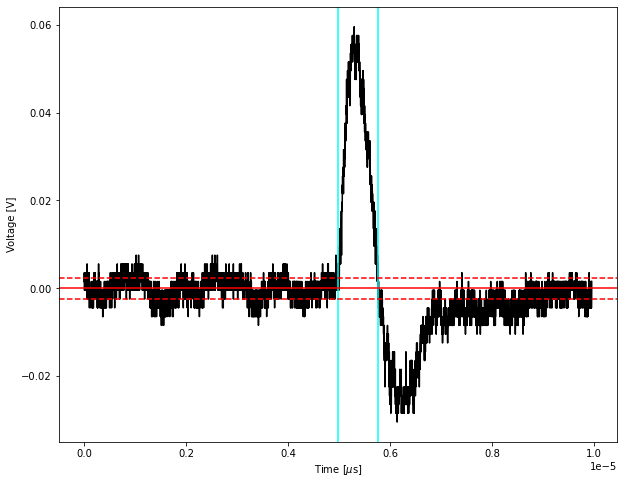

Integral 1 from sum: 26.677551020408167
Integral from trap rule: 9.996999999999987e-09


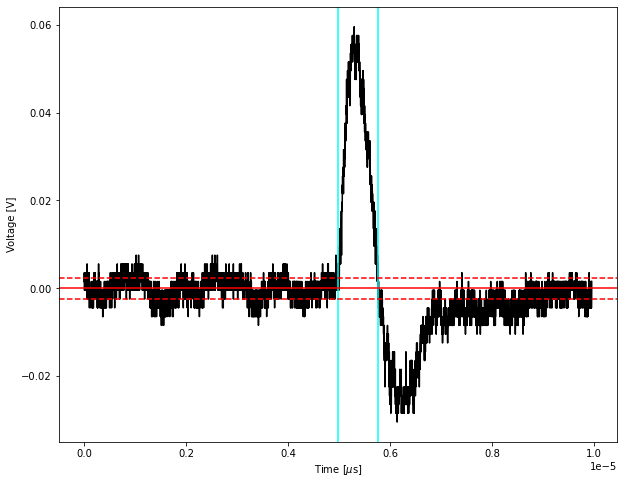

Integral 2 from sum: 26.677551020408167
Integral from trap rule: 9.996999999999987e-09


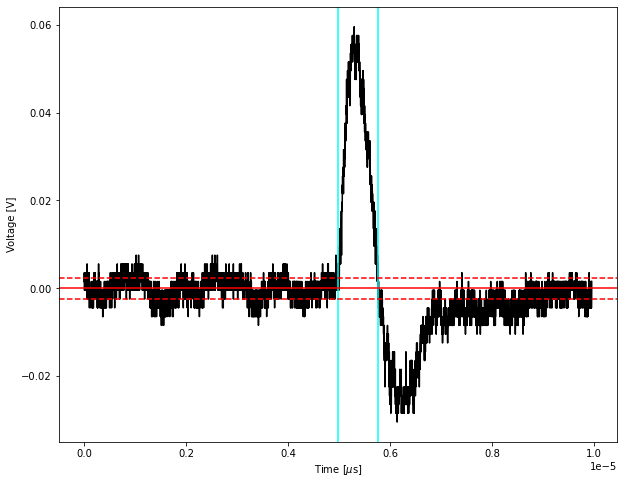

Integral 3 from sum: 27.036755918367344
Integral from trap rule: 9.996999999999987e-09


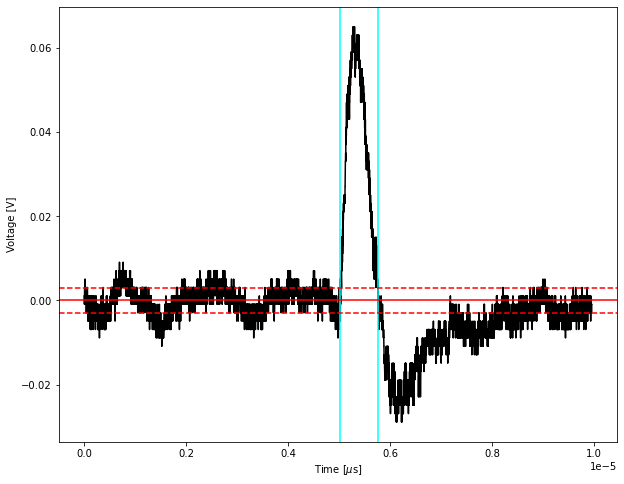

Integral 4 from sum: 27.036755918367344
Integral from trap rule: 9.996999999999987e-09


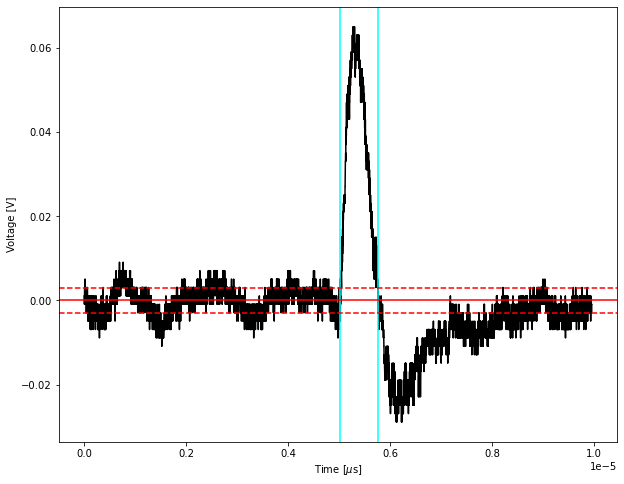

Integral 5 from sum: 28.454045714285712
Integral from trap rule: 9.996999999999987e-09


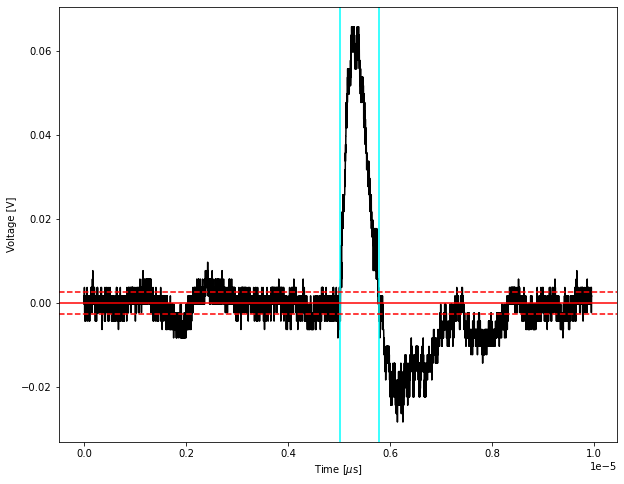

Integral 6 from sum: 25.94002
Integral from trap rule: 9.996999999999987e-09


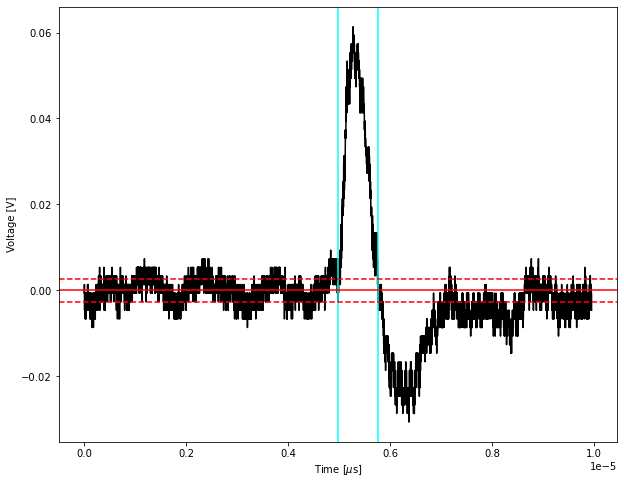

Integral 7 from sum: 28.41521142857142
Integral from trap rule: 9.996999999999987e-09


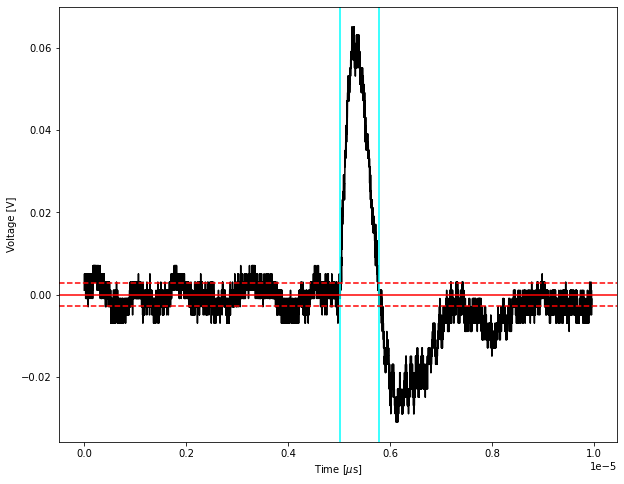

Integral 8 from sum: 28.41521142857142
Integral from trap rule: 9.996999999999987e-09


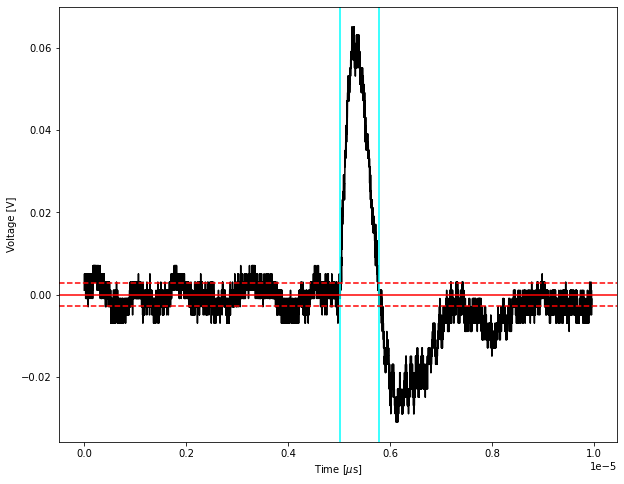

Integral 9 from sum: 29.26103102040816
Integral from trap rule: 9.996999999999987e-09


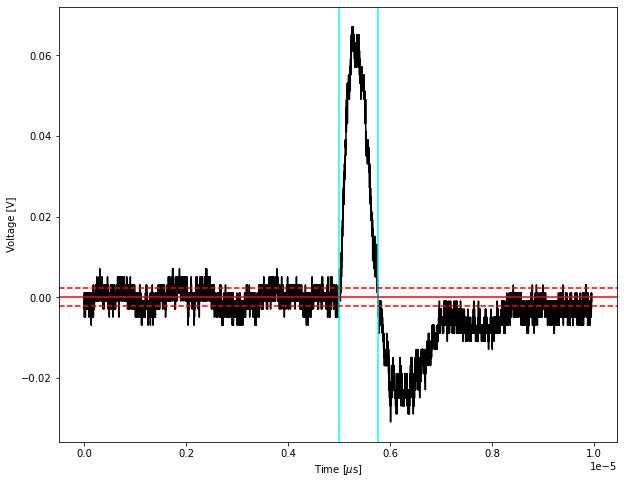

In [99]:
trace_time = traces[:, 0]
# All columns except the first will contain voltages
voltages = traces[:, 1:]
print('Voltages shape:', voltages.shape)
num_traces = voltages.shape[1] # Non-time columns will contain voltages
print('Num traces:', num_traces)
integrals = []
alt_integrals = []
for i in range(num_traces):
    #print('-------START LOOP ', i, '----------')
    voltage = voltages[:,i]
    # TODO: 4900 comes from looking at lbounds output by find_integration_bounds()
    voltage_baseline = np.array(voltage[:4900])
    baseline = np.mean(voltage_baseline)
    #print('Baseline value:', baseline)
    baseline_rms = np.std(voltage_baseline)
    #print('Baseline RMS:', baseline_rms)
    lbound, rbound = find_integration_bounds(voltage, baseline, baseline_rms)
    voltage_baseline_subtracted = voltage - baseline
    integrals.append(np.sum(voltage_baseline_subtracted[lbound:rbound+1]))
    print('Integral', i, 'from sum:', integrals[i])
    alt_integrals.append(np.trapz(voltage_baseline_subtracted[lbound:rbound+1], x=trace_time[lbound:rbound+1]))
    print('Integral from trap rule:', alt_integral)
    #print(voltage)
    #print('len voltage', len(voltage))
    
    ### Plot for validating/debugging ###
    plt.figure(figsize=(10, 8))
    plt.plot(trace_time, voltage_baseline_subtracted, color='black')
    plt.axvline(x=trace_time[lbound], color='cyan')
    plt.axvline(x=trace_time[rbound], color='cyan')
    baseline = 0 # Lazy cheating, I know
    plt.axhline(y=baseline, color='r')
    plt.axhline(y=baseline-baseline_rms, color='r', linestyle='--')
    plt.axhline(y=baseline+baseline_rms, color='r', linestyle='--')
    plt.xlabel(r'Time [$\mu$s]')
    plt.ylabel('Voltage [V]')
    plt.savefig(f"waveform_{i:03}_{filename.removesuffix('.csv')}.png")
    plt.show()
    #print('-------END LOOP ', i, '----------')

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 9.]),
 array([ 0.        ,  2.9261031 ,  5.8522062 ,  8.77830931, 11.70441241,
        14.63051551, 17.55661861, 20.48272171, 23.40882482, 26.33492792,
        29.26103102]),
 <BarContainer object of 10 artists>)

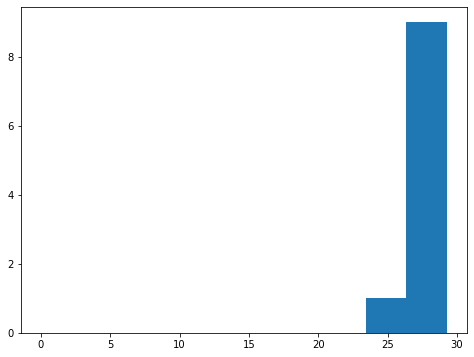

In [100]:
plt.figure(figsize=(8,6))
plt.hist(integrals, range=(0, np.max(integrals)))

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 9.]),
 array([0.00000000e+00, 2.92609478e-09, 5.85218955e-09, 8.77828433e-09,
        1.17043791e-08, 1.46304739e-08, 1.75565687e-08, 2.04826634e-08,
        2.34087582e-08, 2.63348530e-08, 2.92609478e-08]),
 <BarContainer object of 10 artists>)

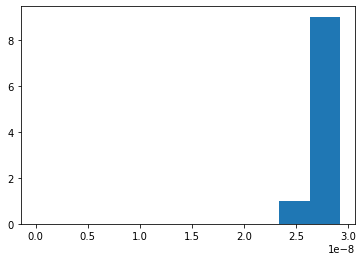

In [85]:
plt.hist(alt_integrals, range=(0, np.max(alt_integrals)))